In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import ParameterGrid
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_excel('GS4.xlsx')
df.sample(2)

,Year,Question
116,2017,“If a country is to be corruption free and bec...
100,2018,Explain the process of resolving ethical dilem...


In [3]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet,stopwords
from nltk import pos_tag
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
import re
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_pe

In [4]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    
    question_words = {'explain', 'what', 'when', 'where', 'who', 'whom', 'which', 'why', 'how', 
                        'comment', 'discuss','following', 'example', 
                        'examine', 'state', 'critically','context', 'measures', 
                        'suggest', 'evaluate', 'describe', 'identify', 'illustrate','can','could','should',
                        'do','does','would','did','will','might'}
    stop_words.update(question_words)
    stop_words = list(stop_words)
    
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r' +', ' ', text)
    
    text = word_tokenize(text)
    filtered_sentence = [w for w in text if not w in stop_words]
    text = ' '.join(filtered_sentence)
    
    def lemmatize_sentence(sentence):
        nltk_tagged = pos_tag(nltk.word_tokenize(sentence))
        
        def nltk2wn_tag(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:          
                return None
    
        wordnet_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
        lemmatized_sentence = []
        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized_sentence.append(word)
            else:
                lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        return " ".join(lemmatized_sentence)
    return lemmatize_sentence(text)
    

In [5]:
text = df.Question[0]
print(text)
filtered_text = preprocess(text)
print(filtered_text)

What do you understand by ‘moral integrity’ and ‘professional efficiency in the context of corporate governance in India ? Illustrate with suitable examples.
understand moral integrity professional efficiency corporate governance india suitable example


In [14]:
def bert_model(df):
    questions = df['Question'].values.tolist()
    lemmatized_questions = [preprocess(question) for question in questions]
    
    param_grid = {
        'n_gram_range': [(1, 2), (1, 3),(1,4)],
        'questions': [lemmatized_questions, questions],
        'embedding_model': ['all-mpnet-base-v2', 'all-MiniLM-L6-v2'],
    }
    
    best_params = None
    best_outliers = float('inf')
    outliers_list = []
    
    representation = [PartOfSpeech("en_core_web_sm"),MaximalMarginalRelevance(diversity=0.2),KeyBERTInspired(top_n_words=30)]
    iteration = 0
    for params in ParameterGrid(param_grid):
        iteration+=1
        print(f"Iteration: {iteration}")
        # print(params)
        sentence_model = SentenceTransformer(params['embedding_model'])
        ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,reduce_frequent_words=True)
        model = BERTopic(embedding_model=sentence_model,representation_model=representation,ctfidf_model=ctfidf_model,verbose=True,calculate_probabilities=True, nr_topics=8, n_gram_range=params['n_gram_range'], min_topic_size=3)
        topics, probs = model.fit_transform(params['questions'])
        
        unique_topics = len(set(topics)) - (1 if -1 in topics else 0)
        
        if unique_topics < 5 :
            continue
        
        outliers_count  = sum(1 for topic in topics if topic == -1)
        outliers_list.append(outliers_count)
        print(f"Outliers: {outliers_count}")
        
        if(outliers_count < best_outliers):
            best_outliers = outliers_count
            best_params = params
            print(f"Best Outliers: {best_outliers}")
            model.save('gs4_model')
            if(best_outliers < 20):
                break

In [15]:
bert_model(df)

Iteration: 1


2024-09-07 09:20:31,922 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]
2024-09-07 09:20:38,456 - BERTopic - Embedding - Completed ✓
2024-09-07 09:20:38,456 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:20:39,884 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:20:39,884 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:20:39,910 - BERTopic - Cluster - Completed ✓
2024-09-07 09:20:39,911 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:20:50,695 - BERTopic - Representation - Completed ✓
2024-09-07 09:20:50,696 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:20:58,377 - BERTopic - Topic reduction - Reduced number of topics from 16 to 8
2024-09-07 09:20:58,405 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the envir

Outliers: 35
Best Outliers: 35
Iteration: 2


2024-09-07 09:21:01,023 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]
2024-09-07 09:21:11,782 - BERTopic - Embedding - Completed ✓
2024-09-07 09:21:11,783 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:21:13,077 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:21:13,077 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:21:13,098 - BERTopic - Cluster - Completed ✓
2024-09-07 09:21:13,098 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:21:24,210 - BERTopic - Representation - Completed ✓
2024-09-07 09:21:24,212 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:21:32,560 - BERTopic - Topic reduction - Reduced number of topics from 14 to 8


Outliers: 41
Iteration: 3


2024-09-07 09:21:34,773 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]
2024-09-07 09:21:41,939 - BERTopic - Embedding - Completed ✓
2024-09-07 09:21:41,939 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:21:44,125 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:21:44,125 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:21:44,144 - BERTopic - Cluster - Completed ✓
2024-09-07 09:21:44,146 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:21:54,898 - BERTopic - Representation - Completed ✓
2024-09-07 09:21:54,898 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:22:02,533 - BERTopic - Topic reduction - Reduced number of topics from 16 to 8


Outliers: 40
Iteration: 4


2024-09-07 09:22:04,522 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]
2024-09-07 09:22:14,562 - BERTopic - Embedding - Completed ✓
2024-09-07 09:22:14,563 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:22:15,739 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:22:15,739 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:22:15,769 - BERTopic - Cluster - Completed ✓
2024-09-07 09:22:15,769 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:22:28,098 - BERTopic - Representation - Completed ✓
2024-09-07 09:22:28,098 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:22:36,439 - BERTopic - Topic reduction - Reduced number of topics from 16 to 8


Outliers: 61
Iteration: 5


2024-09-07 09:22:38,431 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]
2024-09-07 09:22:45,677 - BERTopic - Embedding - Completed ✓
2024-09-07 09:22:45,677 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:22:46,839 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:22:46,839 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:22:46,839 - BERTopic - Cluster - Completed ✓
2024-09-07 09:22:46,857 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:23:00,636 - BERTopic - Representation - Completed ✓
2024-09-07 09:23:00,636 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:23:08,794 - BERTopic - Topic reduction - Reduced number of topics from 20 to 8


Outliers: 60
Iteration: 6


2024-09-07 09:23:10,827 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:09<00:00,  1.43s/it]
2024-09-07 09:23:20,837 - BERTopic - Embedding - Completed ✓
2024-09-07 09:23:20,837 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:23:21,981 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:23:21,981 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:23:21,994 - BERTopic - Cluster - Completed ✓
2024-09-07 09:23:21,996 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:23:33,319 - BERTopic - Representation - Completed ✓
2024-09-07 09:23:33,321 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:23:41,710 - BERTopic - Topic reduction - Reduced number of topics from 14 to 8


Outliers: 42
Iteration: 7


2024-09-07 09:23:43,660 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]
2024-09-07 09:23:44,610 - BERTopic - Embedding - Completed ✓
2024-09-07 09:23:44,610 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:23:45,853 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:23:45,854 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:23:45,878 - BERTopic - Cluster - Completed ✓
2024-09-07 09:23:45,878 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:23:48,298 - BERTopic - Representation - Completed ✓
2024-09-07 09:23:48,298 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:23:49,900 - BERTopic - Topic reduction - Reduced number of topics from 13 to 8
2024-09-07 09:23:49,931 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the envir

Outliers: 23
Best Outliers: 23
Iteration: 8


2024-09-07 09:23:53,135 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]
2024-09-07 09:23:54,256 - BERTopic - Embedding - Completed ✓
2024-09-07 09:23:54,256 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:23:55,498 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:23:55,498 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:23:55,527 - BERTopic - Cluster - Completed ✓
2024-09-07 09:23:55,528 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:23:58,119 - BERTopic - Representation - Completed ✓
2024-09-07 09:23:58,120 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:24:00,025 - BERTopic - Topic reduction - Reduced number of topics from 14 to 8


Outliers: 29
Iteration: 9


2024-09-07 09:24:02,160 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]
2024-09-07 09:24:03,053 - BERTopic - Embedding - Completed ✓
2024-09-07 09:24:03,054 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:24:04,791 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:24:04,791 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:24:04,804 - BERTopic - Cluster - Completed ✓
2024-09-07 09:24:04,805 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:24:06,927 - BERTopic - Representation - Completed ✓
2024-09-07 09:24:06,931 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:24:08,854 - BERTopic - Topic reduction - Reduced number of topics from 13 to 8


Outliers: 30
Iteration: 10


2024-09-07 09:24:10,862 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]
2024-09-07 09:24:11,913 - BERTopic - Embedding - Completed ✓
2024-09-07 09:24:11,913 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:24:13,098 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:24:13,098 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:24:13,136 - BERTopic - Cluster - Completed ✓
2024-09-07 09:24:13,137 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:24:15,662 - BERTopic - Representation - Completed ✓
2024-09-07 09:24:15,662 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:24:17,648 - BERTopic - Topic reduction - Reduced number of topics from 14 to 8


Outliers: 30
Iteration: 11


2024-09-07 09:24:19,732 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:00<00:00,  9.21it/s]
2024-09-07 09:24:20,498 - BERTopic - Embedding - Completed ✓
2024-09-07 09:24:20,498 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:24:21,715 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:24:21,715 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:24:21,737 - BERTopic - Cluster - Completed ✓
2024-09-07 09:24:21,738 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:24:24,377 - BERTopic - Representation - Completed ✓
2024-09-07 09:24:24,377 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:24:26,457 - BERTopic - Topic reduction - Reduced number of topics from 14 to 8


Outliers: 31
Iteration: 12


2024-09-07 09:24:28,421 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:01<00:00,  6.41it/s]
2024-09-07 09:24:29,521 - BERTopic - Embedding - Completed ✓
2024-09-07 09:24:29,521 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:24:30,810 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:24:30,812 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:24:30,844 - BERTopic - Cluster - Completed ✓
2024-09-07 09:24:30,844 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:24:33,877 - BERTopic - Representation - Completed ✓
2024-09-07 09:24:33,877 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:24:35,937 - BERTopic - Topic reduction - Reduced number of topics from 16 to 8


Outliers: 36


In [16]:
model = BERTopic.load('gs4_model')

In [17]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,23,-1_integrity civil_ethical value_moral quality...,"[integrity civil, ethical value, moral quality...",[mere compliance law enough public servant als...
1,0,95,0_management_employee_officer_manager,"[management, employee, officer, manager, distr...",[rajesh kumar senior public servant reputation...
2,1,36,1_civil servant_integrity_positive attitude_co...,"[civil servant, integrity, positive attitude, ...",[attitude towards life work people society gen...
3,2,19,2_mahatma gandhi_gandhi_abdul kalam_three quot...,"[mahatma gandhi, gandhi, abdul kalam, three qu...",[country corruption free become nation beautif...
4,3,15,3_public service_service impartiality_public s...,"[public service, service impartiality, public ...",[ten essential value need effective public ser...
5,4,8,4_governance understand_governance ethical_pro...,"[governance understand, governance ethical, pr...",[understand moral integrity professional effic...
6,5,8,5_emotional intelligence_conscience emotional_...,"[emotional intelligence, conscience emotional,...",[emotional intelligence ability make emotion w...
7,6,4,6_corruption among_indulge corruption_corrupti...,"[corruption among, indulge corruption, corrupt...",[corruption manifestation failure core value s...


In [18]:
questions = df['Question'].values.tolist()

In [ ]:
model.visualize_documents(questions)

In [20]:
model.get_representative_docs()

{-1: ['mere compliance law enough public servant also well developed sensibility ethical issue effective discharge duty agree help two example act ethically right legally ii act legally right ethically',
  'recent time increase concern india develop effective civil service ethic code conduct transparency ethic integrity system anticorruption agency view need felt focus three specific area directly relevant problem internalize integrity ethic civil service follow anticipate specific threat ethical standard integrity civil service strengthen ethical competence civil servant develop administrative process practice promote ethical value integrity civil service institutional address three issue',
  'modern democratic polity concept political executive permanent executive elect people representative form political executive bureaucracy forms permanent executive minister frame policy decision bureaucrat execute initial decade independence relationship permanent executive political executive c

In [21]:
num_words = 10
topics_ = []
for topic_num in range(len(model.get_topics())):
    # if topic_num != -1:   #-1 is the outlier class in BERTopic
    topic = model.get_topic(topic_num-1)
    if topic:  # Check if topic is not None
        top_words = [word for word, _ in topic[:num_words]]
        top_words = " ".join(top_words)
        topics_.append(f"Topic {topic_num}: {top_words}")

len(model.get_topics())

8

In [22]:
topics_

['Topic 0: integrity civil ethical value moral quality integrity public servant ethical ethic civil service politicization bureaucracy identify bureaucratic',
 'Topic 1: management employee officer manager district department ministry chief government report',
 'Topic 2: civil servant integrity positive attitude contrast attitude law ethic servant implicate civil ethical mean attitude towards morality',
 'Topic 3: mahatma gandhi gandhi abdul kalam three quotation mahatma thinkersphilosophers quotation moral thinkersphilosophers quotation quotation mean quotation great',
 'Topic 4: public service service impartiality public servant service courage service spirit value public role public service transparency service justify service understand',
 'Topic 5: governance understand governance ethical probity governance good governance governance good ethical governance governance term governance corporate governance governance base',
 'Topic 6: emotional intelligence conscience emotional emot

In [23]:
topic_names = {0:'Outliers',1:'Management and Organizational Roles',2:'Attitudes and Morality of Civil Servants',3:'Quotations and Philosophers',4:'Public Service and Transparency',5:'Governance and Ethical Practices',6:'Emotional Intelligence and Conscience',7:' Corruption and Its Manifestations'}
num_words = 10
topics_ = {}
for topic_num in range(len(model.get_topics())):
    # if topic_num != -1:   #-1 is the outlier class in BERTopic
    topic = model.get_topic(topic_num-1)
    if topic:  # Check if topic is not None
        top_words = [word for word, _ in topic[:num_words]]
        topics_[topic_names[topic_num]] = top_words

In [24]:
topics_

{'Outliers': ['integrity civil',
  'ethical value',
  'moral quality',
  'integrity',
  'public servant',
  'ethical',
  'ethic',
  'civil service',
  'politicization bureaucracy',
  'identify bureaucratic'],
 'Management and Organizational Roles': ['management',
  'employee',
  'officer',
  'manager',
  'district',
  'department',
  'ministry',
  'chief',
  'government',
  'report'],
 'Attitudes and Morality of Civil Servants': ['civil servant',
  'integrity',
  'positive attitude',
  'contrast attitude',
  'law ethic',
  'servant implicate',
  'civil',
  'ethical mean',
  'attitude towards',
  'morality'],
 'Quotations and Philosophers': ['mahatma gandhi',
  'gandhi',
  'abdul kalam',
  'three quotation',
  'mahatma',
  'thinkersphilosophers quotation',
  'moral thinkersphilosophers',
  'quotation',
  'quotation mean',
  'quotation great'],
 'Public Service and Transparency': ['public service',
  'service impartiality',
  'public servant',
  'service courage',
  'service spirit',
  '

In [25]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')
question_embeddings = sbert_model.encode(questions)

topic_embeddings = {}
for i in range(len(topics_.items())):
    topic_embeddings[topic_names[i]] = []
    for word in topics_[topic_names[i]]:
        topic_embeddings[topic_names[i]].append(sbert_model.encode(word))
        
topic_embeddings

{'Outliers': [array([-8.51851422e-03,  1.42639101e-01, -2.92806630e-03, -3.83877289e-03,
         -3.76569666e-02,  1.48138385e-02,  2.57407352e-02,  2.80595701e-02,
         -3.80085595e-02, -1.24223055e-02,  4.82443981e-02, -5.04080206e-02,
          3.33562791e-02,  3.09071895e-02, -2.37790849e-02,  2.49577290e-03,
          7.35849794e-03,  1.74796358e-02,  1.09896008e-02, -1.23191625e-02,
         -2.73612384e-02,  1.49886198e-02,  9.93016176e-03,  1.03541939e-02,
          2.17929971e-03, -1.97592918e-02,  1.85726713e-02,  1.75150596e-02,
         -4.43871319e-02, -1.32108657e-02, -4.96773515e-03,  4.11181077e-02,
         -1.59681700e-02,  3.93932639e-03,  1.77930372e-06, -2.41779331e-02,
         -9.28468443e-03, -3.09715550e-02, -5.79997003e-02,  4.29587550e-02,
         -3.69079672e-02,  3.51231433e-02, -4.84780259e-02, -6.40957383e-03,
         -4.38065641e-02,  5.98522276e-02,  1.40803512e-02,  3.42149138e-02,
         -1.68649983e-02,  4.28134166e-02, -6.29317900e-03, -5.6

In [26]:
from sentence_transformers import CrossEncoder
crossencoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')


In [27]:
question = questions[77]
topics_nearest = []
for i in range(len(topics_.items())):
    for word in topics_[topic_names[i]]:
        score = crossencoder.predict([(question,word)])
        topics_nearest.append({topic_names[i]: [score.tolist()[0],word]})

topics_nearest

[{'Outliers': [-10.05807113647461, 'integrity civil']},
 {'Outliers': [-9.853102684020996, 'ethical value']},
 {'Outliers': [-9.68414306640625, 'moral quality']},
 {'Outliers': [-9.62649154663086, 'integrity']},
 {'Outliers': [-8.604415893554688, 'public servant']},
 {'Outliers': [-9.004849433898926, 'ethical']},
 {'Outliers': [-9.602447509765625, 'ethic']},
 {'Outliers': [-10.368326187133789, 'civil service']},
 {'Outliers': [-10.170931816101074, 'politicization bureaucracy']},
 {'Outliers': [-10.457403182983398, 'identify bureaucratic']},
 {'Management and Organizational Roles': [-9.795648574829102, 'management']},
 {'Management and Organizational Roles': [-9.598408699035645, 'employee']},
 {'Management and Organizational Roles': [-9.708642959594727, 'officer']},
 {'Management and Organizational Roles': [-9.880379676818848, 'manager']},
 {'Management and Organizational Roles': [-9.753057479858398, 'district']},
 {'Management and Organizational Roles': [-9.47938060760498, 'department'

In [28]:
topics_nearest.sort(key=lambda x: list(x.values())[0],reverse=True)
top_7_nearest = topics_nearest[:7]
top_7_nearest

[{'Emotional Intelligence and Conscience': [-0.6346886157989502,
   'crisis conscience']},
 {'Emotional Intelligence and Conscience': [-6.125213623046875,
   'conscience emotional']},
 {'Public Service and Transparency': [-8.228865623474121, 'role public']},
 {' Corruption and Its Manifestations': [-8.368295669555664,
   'corruption manifestation']},
 {'Attitudes and Morality of Civil Servants': [-8.557136535644531,
   'ethical mean']},
 {'Outliers': [-8.604415893554688, 'public servant']},
 {'Public Service and Transparency': [-8.604415893554688, 'public servant']}]

In [29]:
highest_scores = {}

for entry in topics_nearest:
    for topic, (score, word) in entry.items():
        if topic not in highest_scores or score > highest_scores[topic][0]:
            highest_scores[topic] = (score, word)

total = sum(score for score,word in highest_scores.values())



closest_topics = {topic:(score/total , word) for topic,(score,word) in highest_scores.items()}


closest_topics

{'Emotional Intelligence and Conscience': (0.010093604784096816,
  'crisis conscience'),
 'Public Service and Transparency': (0.1308656171817941, 'role public'),
 ' Corruption and Its Manifestations': (0.13308300653642105,
  'corruption manifestation'),
 'Attitudes and Morality of Civil Servants': (0.1360861879736494,
  'ethical mean'),
 'Outliers': (0.13683808290497768, 'public servant'),
 'Management and Organizational Roles': (0.14620094624845686, 'ministry'),
 'Governance and Ethical Practices': (0.14986732886280968, 'governance'),
 'Quotations and Philosophers': (0.1569652255077944, 'quotation mean')}

In [30]:
def score_generate(question):
    topics_nearest = []
    for i in range(len(topics_.items())):
        for word in topics_[topic_names[i]]:
            score = crossencoder.predict([(question,word)])
            topics_nearest.append({topic_names[i]: [score.tolist()[0],word]})
    
    highest_scores = {}
    for entry in topics_nearest:
        for topic, (score, word) in entry.items():
            if topic not in highest_scores or score > highest_scores[topic][0]:
                highest_scores[topic] = (score, word)

    total = sum(score for score,word in highest_scores.values())
    closest_topics = {topic:(score/total) for topic,(score,word) in highest_scores.items()}
    return closest_topics

In [31]:
data = pd.DataFrame()

for i in range(len(questions)):
    data_ = pd.DataFrame(score_generate(questions[i]),index=[i])
    data_['Question'] = questions[i]
    
    data = pd.concat([data,data_],ignore_index=True)

In [32]:
data.sample(5)


,Outliers,Management and Organizational Roles,Attitudes and Morality of Civil Servants,Quotations and Philosophers,Public Service and Transparency,Governance and Ethical Practices,Emotional Intelligence and Conscience,Corruption and Its Manifestations,Question
98,0.107402,0.138188,0.084722,0.120051,0.117140,0.140453,0.148384,0.143660,"With regard to the morality of actions, one vi..."
114,0.122306,0.108747,0.126994,0.145321,0.127022,0.071614,0.151797,0.146199,Corporate social responsibility makes companie...
142,0.125183,0.125125,0.124555,0.123279,0.125447,0.125716,0.126099,0.124596,"Land needed for mining, dams and other large-s..."
12,0.131882,0.124938,0.136074,0.142248,0.129568,0.047549,0.147998,0.139743,Explain the term social capital. How does it e...
119,0.056324,0.155025,0.113465,0.149692,0.155786,0.099081,0.110284,0.160342,The crisis of ethical values in modern times i...


In [33]:
data['Topic'] = data.iloc[:,:-1].idxmin(axis=1)
data['Year'] = df['Year']
data.sample(5)

,Outliers,Management and Organizational Roles,Attitudes and Morality of Civil Servants,Quotations and Philosophers,Public Service and Transparency,Governance and Ethical Practices,Emotional Intelligence and Conscience,Corruption and Its Manifestations,Question,Topic,Year
174,0.129215,0.127524,0.086941,0.128839,0.131593,0.136136,0.133084,0.126669,What factors affect the formation of a person’...,Attitudes and Morality of Civil Servants,2014
53,0.124703,0.128061,0.125942,0.119304,0.126023,0.126230,0.124112,0.125625,A Reputed food product company based in India ...,Quotations and Philosophers,2021
118,0.106438,0.110237,0.106438,0.135704,0.126264,0.120337,0.151158,0.143424,"Strength, peace and security are considered to...",Outliers,2017
194,0.097680,0.157803,0.101054,0.006993,0.166118,0.155990,0.159274,0.155087,Given below are three quotations of great mora...,Quotations and Philosophers,2013
158,0.123783,0.119558,0.127892,0.128049,0.123489,0.121733,0.127223,0.128272,You are the Sarpanch of a Panchayat. There is ...,Management and Organizational Roles,2015


In [34]:
data.to_excel('GS4_topics_v1.xlsx', index=False)

In [35]:
data = pd.read_excel('GS4_topics_v1.xlsx')

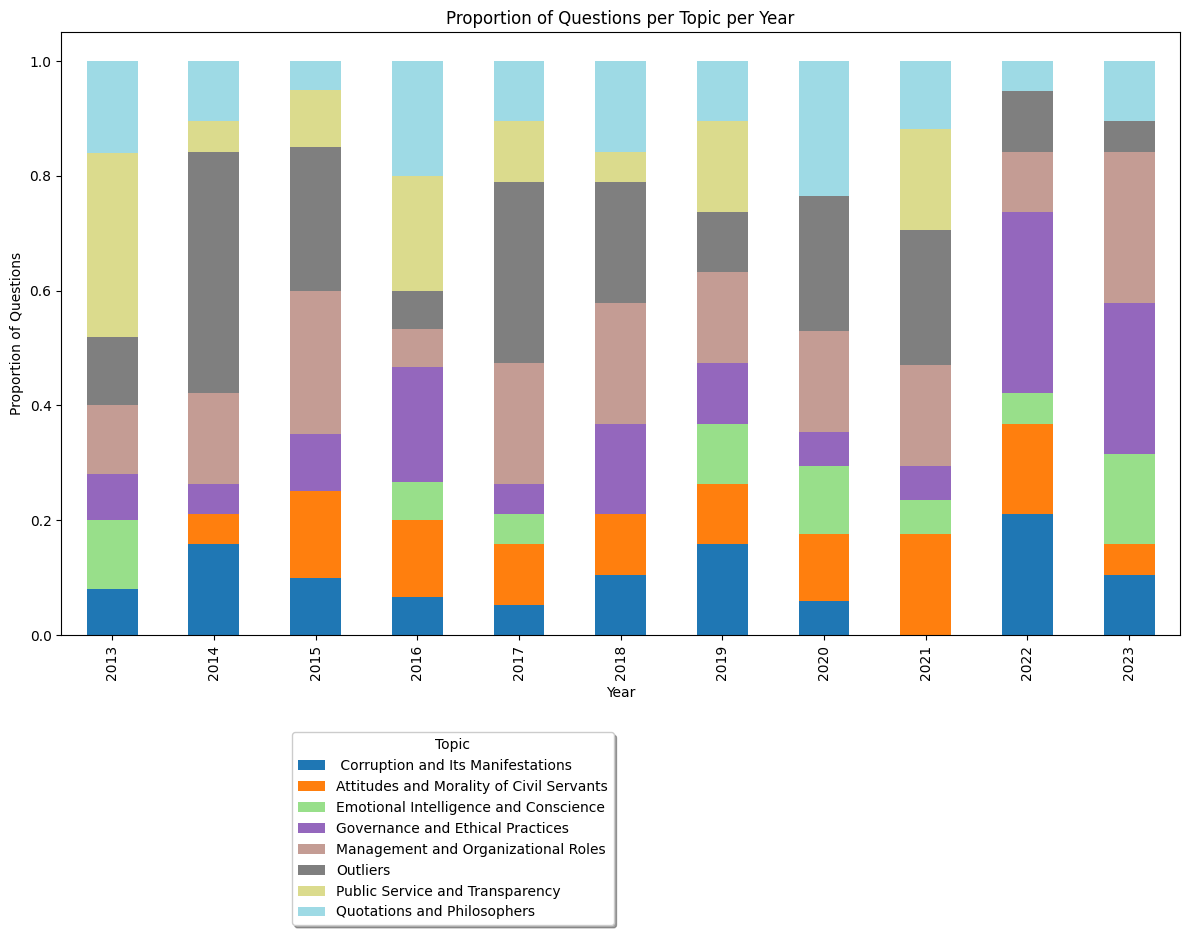

In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Step 2: Count questions per topic per year
topic_year_counts = data.groupby(['Year', 'Topic']).size().reset_index(name='Count')

# Calculate the total number of questions per year
total_questions_per_year = topic_year_counts.groupby('Year')['Count'].transform('sum')

# Calculate the proportion of questions per topic per year
topic_year_counts['Proportion'] = topic_year_counts['Count'] / total_questions_per_year

# Step 3: Prepare data for plotting (normalized)
pivot_table = topic_year_counts.pivot(index='Year', columns='Topic', values='Proportion')

# Generate a list of colors from a colormap
num_topics = len(pivot_table.columns)
colors = plt.get_cmap('tab20', num_topics)

# Step 4: Plot the normalized data with different colors for each topic
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8), color=[colors(i) for i in range(num_topics)])

# Step 5: Customize the plot
plt.xlabel('Year')
plt.ylabel('Proportion of Questions')
plt.title('Proportion of Questions per Topic per Year')
plt.legend(title='Topic', loc='best', bbox_to_anchor=(0.5, -0.15), ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

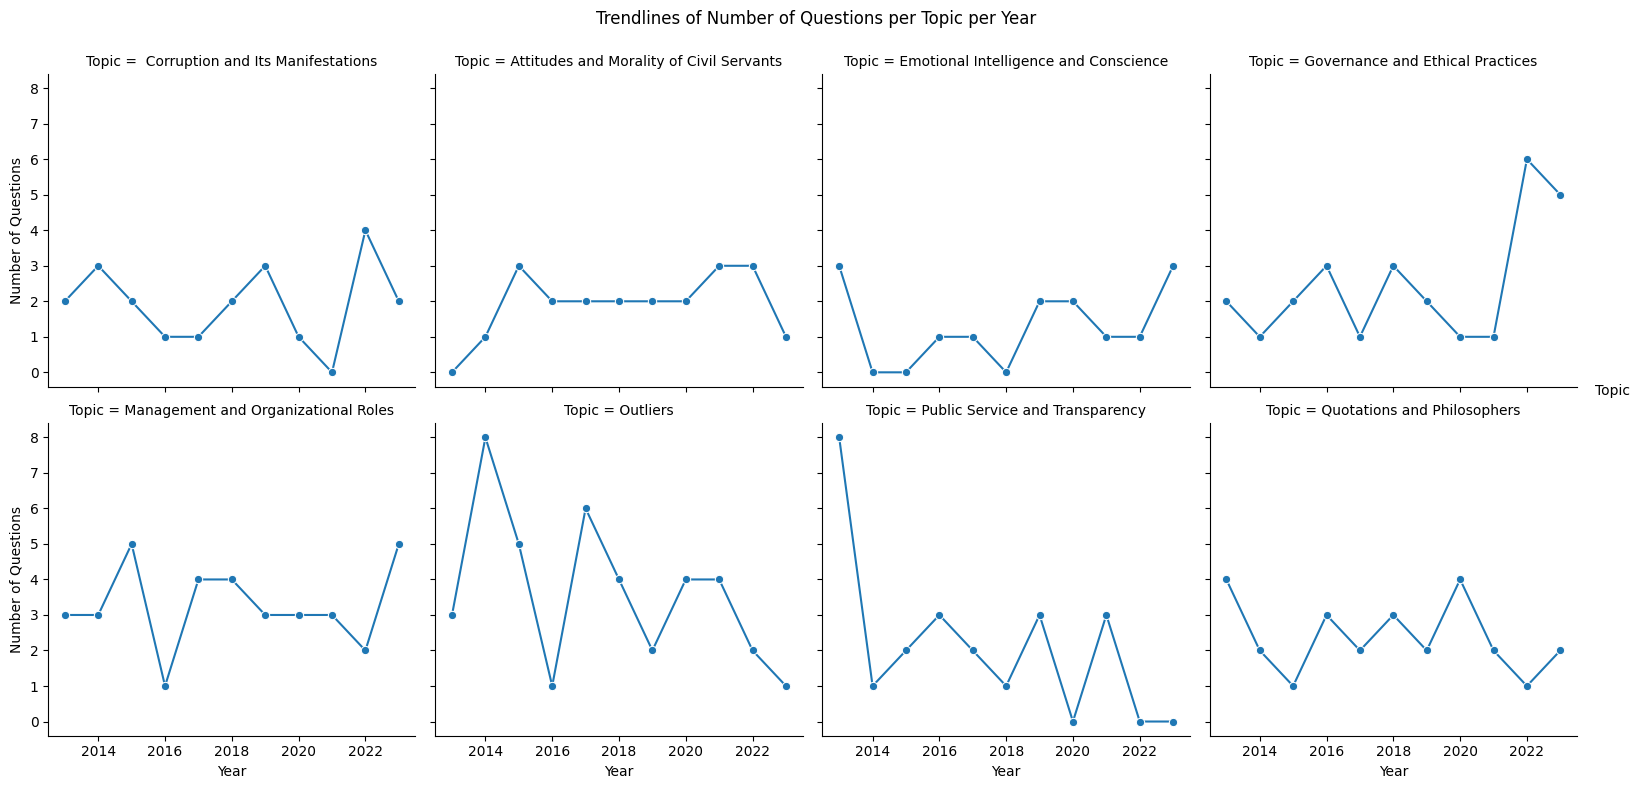

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

topic_year_counts = pd.crosstab(data['Year'], data['Topic'])

# Reset index to convert the pivot table to a DataFrame
topic_year_counts = topic_year_counts.reset_index()

# Melt the DataFrame to long format for Seaborn
melted_topic_year_counts = topic_year_counts.melt(id_vars='Year', var_name='Topic', value_name='Count')


g = sns.FacetGrid(melted_topic_year_counts, col='Topic', col_wrap=4, height=4, sharex=True, sharey=True)
g.map(sns.lineplot, 'Year', 'Count', marker='o')
g.set_axis_labels('Year', 'Number of Questions')
g.add_legend(title='Topic')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Trendlines of Number of Questions per Topic per Year')
plt.show()


<Axes: title={'center': 'Topic Frequency'}, xlabel='Topics', ylabel='Number Of Questions'>

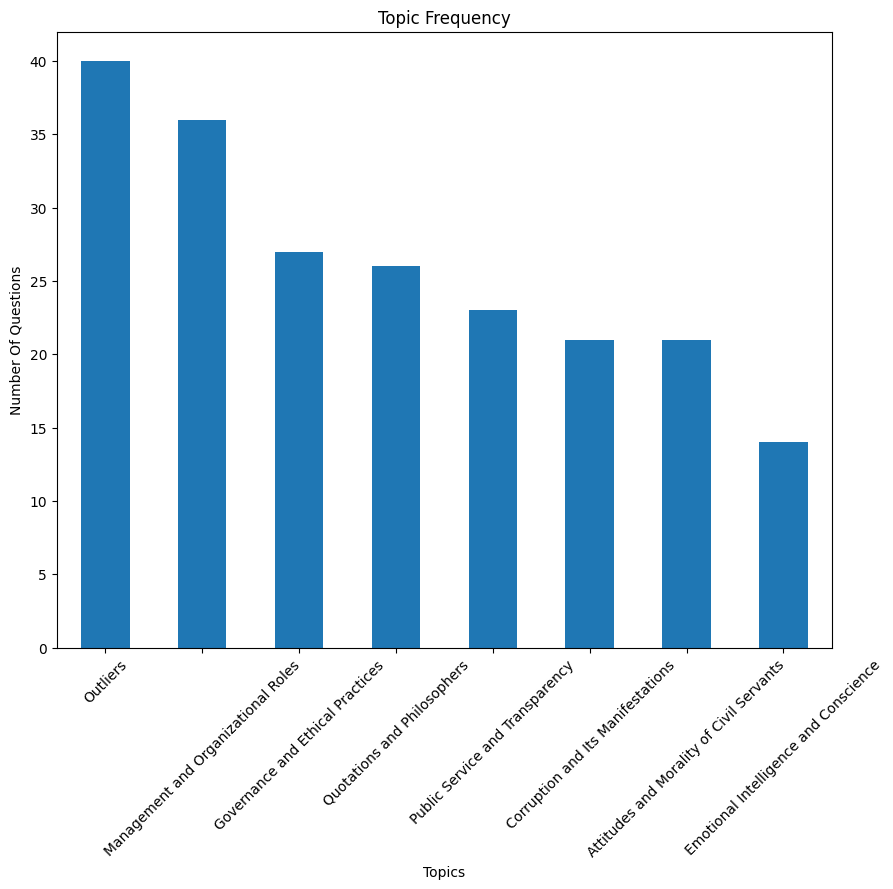

In [39]:
data.Topic.value_counts().plot(kind='bar', figsize=(10, 8), title='Topic Frequency', xlabel='Topics', ylabel='Number Of Questions', rot=45)